# Data

In [1]:
import pandas as pd
import numpy as np
from SupportFunctions import preprocess_impute_spaceship_titanic

In [2]:
test_raw = pd.read_csv("./spaceship-titanic/test.csv")

In [3]:
def bin_feature(df, feat_name, bins):
    """
    Put feature in bins and drop old column.
    
    Returns dataframe with new feature.
    """
    
    new_df = df.copy()
    
    # Transform to int64 column with NaNs for string 'Missing'
    new_df[feat_name] = new_df[feat_name].map(lambda x: np.NaN if x=="Missing" else x).astype('Int64', errors='ignore') # Missing is Nan again
    
    # Cut in bins
    new_df[feat_name] = pd.cut(new_df[feat_name], bins=bins, include_lowest=True)
    
    return new_df

In [4]:
# Bin features is dict
from sklearn.preprocessing import LabelEncoder

def read_preprocess_titanic(cat_features,
                            drop_features,
                            bin_features,
                            one_hot=True,
                            log_transform_exp=False,
                            proba_imp=True,
                            expense_strat="group_median",
                            age_strat="group_mean",
                            drop_outliers=False):

    train_raw = pd.read_csv("./spaceship-titanic/train.csv")
    test_raw = pd.read_csv(("./spaceship-titanic/test.csv"))


    # Preprocess train 
    train = preprocess_impute_spaceship_titanic(train_raw, 
                                                log_transform_exp=log_transform_exp, 
                                                proba_imp=proba_imp, 
                                                expense_strat=expense_strat, 
                                                age_strat=age_strat,
                                                drop_outliers=drop_outliers)

    # Preprocess test in same way
    test = preprocess_impute_spaceship_titanic(test_raw, 
                                               log_transform_exp=log_transform_exp, 
                                               proba_imp=proba_imp, 
                                               expense_strat=expense_strat, 
                                               age_strat=age_strat,
                                               drop_outliers=drop_outliers)
    
    # Bin features
    for name, feat_bins in bin_features.items():
        train = bin_feature(train, name, bins=feat_bins)
        test = bin_feature(test, name, bins=feat_bins)
        
        # Add feature to categorical features
        cat_features.append(name)
        
    
    # Convert to dummies 
    if one_hot:
        train = pd.concat([train, pd.get_dummies(train[cat_features])], axis=1)
        train = train.drop(cat_features, axis=1)
        
        test = pd.concat([test, pd.get_dummies(test[cat_features])], axis=1)
        test = test.drop(cat_features, axis=1)
    
    # Encode as labels
    else:
        for feat in cat_features:
            LE = LabelEncoder().fit(train[feat])
            train[feat] = LE.transform(train[feat])
            test[feat] = LE.transform(test[feat])
            
    # Drop features
    train = train.drop(drop_features, axis=1)

    # Same for test
    test = test.drop(drop_features, axis=1)


    y = train.Transported.copy()
    X = train.drop("Transported", axis=1).copy()
    
    return X, test, y

In [5]:
#Categorical features we want to include in the models
cat_features = ['HomePlanet', 'Destination', 'Deck', 'Side']
bool_features = ['CryoSleep', 'VIP', 'NoExpenses', 'Alone']
drop_features = ['PassengerId', 'Name', 'GroupID', 'CabinNum']
num_features = ['Age', 'TotalExp', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupPos']

# DecTree

In [406]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name'],
                                     bin_features={'CabinNum':(0, 473, 947, 1420, 1895)},
                                     one_hot=True)


In [174]:
from sklearn.feature_selection import RFECV

base = RandomForestClassifier(n_estimators=800, max_depth=8)
selector = RFECV(base, cv=5, n_jobs=-1)
#np.mean(cross_val_score(RandomForestClassifier(), X, y, cv=10))

In [175]:
selector.fit(X,y)

RFECV(cv=5, estimator=RandomForestClassifier(max_depth=8, n_estimators=800),
      n_jobs=-1)

In [177]:
selector.feature_names_in_[selector.support_]

array(['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'TotalExp', 'GroupID', 'GroupSize', 'NoExpenses',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Deck_E', 'Deck_F', 'Deck_G', 'Side_S'], dtype=object)

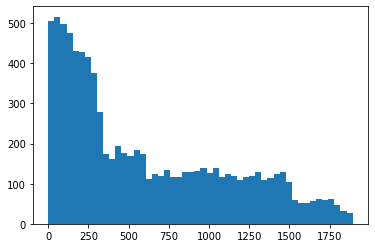

In [19]:
import matplotlib.pyplot as plt

plt.hist(X[X.CabinNum!="Missing"].CabinNum.astype(int), bins=50)
plt.show()

(array([4541., 1725., 1531.,  797.]),
 array([   0. ,  473.5,  947. , 1420.5, 1894. ]),
 <BarContainer object of 4 artists>)

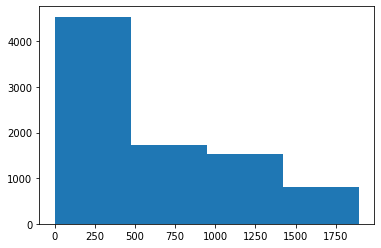

In [23]:
# Do it in 4
plt.hist(X[X.CabinNum!="Missing"].CabinNum.astype(int), bins=4)

In [110]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    8693 non-null   category
 1   CryoSleep     8693 non-null   bool    
 2   Destination   8693 non-null   category
 3   Age           8693 non-null   int64   
 4   VIP           8693 non-null   bool    
 5   RoomService   8693 non-null   float64 
 6   FoodCourt     8693 non-null   float64 
 7   ShoppingMall  8693 non-null   float64 
 8   Spa           8693 non-null   float64 
 9   VRDeck        8693 non-null   float64 
 10  TotalExp      8693 non-null   float64 
 11  GroupPos      8693 non-null   int64   
 12  GroupSize     8693 non-null   int64   
 13  Deck          8693 non-null   category
 14  CabinNum      8594 non-null   category
 15  Side          8693 non-null   category
 16  NoExpenses    8693 non-null   bool    
 17  Alone         8693 non-null   bool    
dtypes: bool(

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


param_grid = {'max_features': [None, 'sqrt', 'log2'],
              'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12],
              'criterion' :['gini', 'entropy'],
              'min_samples_split': [2, 4, 10, 15, 20, 25, 30, 35, 50], 
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 50]
             }

decTree = DecisionTreeClassifier(random_state=123)
grid_search_DT = GridSearchCV(estimator=decTree, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_DT.fit(X, y)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


KeyboardInterrupt: 

In [58]:
param_grid = {'max_features': [None],
              'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12],
              'criterion' :['gini', 'entropy'],
              'min_samples_split': [2, 4, 10], 
              'min_samples_leaf': [5, 6, 7, 8, 10]
             }

decTree = DecisionTreeClassifier(random_state=123)
grid_search_DT = GridSearchCV(estimator=decTree, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_DT.fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': [None],
                         'min_samples_leaf': [5, 6, 7, 8, 10],
                         'min_samples_split': [2, 4, 10]},
             verbose=1)

In [59]:
grid_search_DT.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 123,
 'splitter': 'best'}

In [60]:
grid_search_DT.best_score_

0.7882218065089058

In [61]:
decTreePred = grid_search_DT.best_estimator_.predict(test)

decTreeSub = test_raw[["PassengerId"]].copy()
decTreeSub["Transported"] = decTreePred

decTreeSub.to_csv("./spaceship-titanic/DecTree.csv", index=False)

# RF

In [279]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum', 'GroupID'],
                                     bin_features={},
                                     one_hot=True)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

In [ ]:
# Cabin num bin_features={'CabinNum':(0, 473, 947, 1420, 1895)

#'criterion' :['gini', 'entropy'],
#    'min_samples_split': [2, 10, 100, 500], 
#    'min_samples_leaf': [1, 10, 100, 500]

In [ ]:
# Adding group ID made it a lot worse!!!

In [330]:
# RandomSearch CV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

distributions = param_grid = { 
        'criterion' :['entropy', 'gini'],
        'n_estimators': randint(low=400, high=3000),
        'max_features': [None, 'sqrt'],
        'max_depth' : randint(low=2, high=40)
}

RF = RandomForestClassifier()
random_search_RF = RandomizedSearchCV(RF, distributions, random_state=123, n_iter=2, n_jobs=-1)
random_search_RF.fit(X,y)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=2, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b6837ee0>,
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b683edc0>},
                   random_state=123)

In [332]:
random_search_RF.cv_results_['params']

[{'criterion': 'entropy',
  'max_depth': 4,
  'max_features': None,
  'n_estimators': 1522},
 {'criterion': 'entropy',
  'max_depth': 19,
  'max_features': 'sqrt',
  'n_estimators': 2554}]

In [334]:
random_search_RF.best_score_

0.7875319532739409

In [335]:
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'criterion' :['entropy'],
    'n_estimators': [700, 1000, 1200, 1400, 1800],
    'max_features': [None, 'sqrt'],
    'max_depth' : [5,6,7,8,9,10]
}

RF = RandomForestClassifier(random_state=123)
grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_RF.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [700, 1000, 1200, 1400, 1800]},
             verbose=1)

In [360]:

param_grid = { 
    'criterion' :['entropy'],
    'n_estimators': [1000, 1100],
    'max_features': ['sqrt'],
    'max_depth' : [8,9,10]
}

RF = RandomForestClassifier(random_state=123)
grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_RF.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
grid_search_RF.best_score_

In [345]:
grid_search_RF.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'sqrt',
 'n_estimators': 1100}

**Best one**

In [411]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum'],
                                     bin_features={},
                                     one_hot=False,
                                     log_transform_exp=False)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

RF_best = RandomForestClassifier(
                      n_estimators=1100, 
                      random_state=123, 
                      criterion='entropy',
                      max_depth=9,
                      max_features='sqrt', 
                      oob_score=True)

RF_best.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=1100,
                       oob_score=True, random_state=123)

In [412]:
RF_best.oob_score_

0.8034050385367537

In [373]:
RF_pred = RF_best.predict(test)

RF_sub = test_raw[["PassengerId"]].copy()
RF_sub["Transported"] = RF_pred

RF_sub.to_csv("./spaceship-titanic/RF_fine_tune_groupid.csv", index=False)

<BarContainer object of 25 artists>

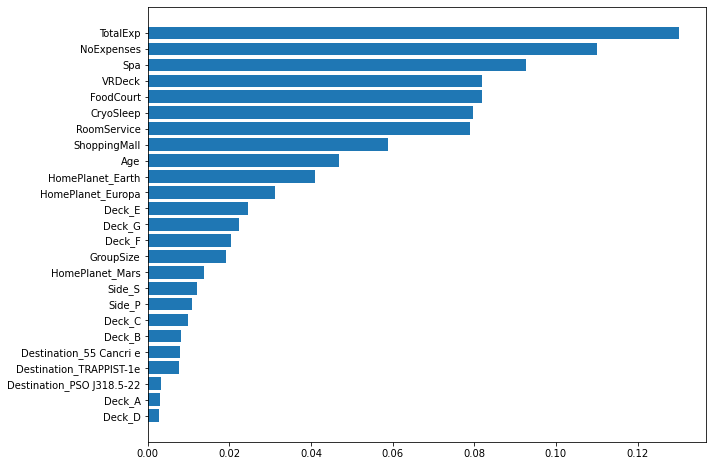

In [349]:
plt.figure(figsize=(10,8))
importances = grid_search_RF.best_estimator_.feature_importances_
names = grid_search_RF.best_estimator_.feature_names_in_
feat_importances = pd.DataFrame({"Name":names, "Importance":importances}).sort_values(by="Importance")
plt.barh(width=feat_importances.Importance, 
         y=feat_importances.Name)

In [219]:
names[importances<0.006]

array(['VIP', 'Alone', 'Destination_PSO J318.5-22', 'Deck_A', 'Deck_D',
       'Deck_T', 'Side_Missing'], dtype=object)

# AB

In [394]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

param_grid = { 
    'n_estimators':[200, 300, 400, 500, 900],
    'learning_rate':[0.2, 0.4, 0.5, 0.6, 0.7, 3]
}

AdaBoost = AdaBoostClassifier(random_state=123)
grid_search_AB = GridSearchCV(estimator=AdaBoost, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_AB.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=123), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.4, 0.5, 0.6, 0.7, 3],
                         'n_estimators': [200, 300, 400, 500, 900]},
             verbose=1)

In [395]:
grid_search_AB.best_estimator_

AdaBoostClassifier(learning_rate=0.5, n_estimators=200, random_state=123)

In [396]:
grid_search_AB.best_score_

0.7915569243067223

In [84]:
AB_pred = grid_search_AB.best_estimator_.predict(test)

AB_sub = test_raw[["PassengerId"]].copy()
AB_sub["Transported"] = AB_pred

AB_sub.to_csv("./spaceship-titanic/AB_cabin.csv", index=False)

## Logistic Regression

In [17]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum', 'GroupID'],
                                     bin_features={},
                                     one_hot=True)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

In [14]:
from sklearn.preprocessing import StandardScaler

SC = StandardScaler().fit(X)
X = SC.transform(X)
test = SC.transform(test)

In [387]:
from sklearn.linear_model import LogisticRegression

params = {
    'penalty': ['l1','l2'], 
    'C': [0.001,0.01,0.1,1,8,10,15,100,1000]
}

LR = LogisticRegression(solver='liblinear')
LR_grid_search = GridSearchCV(estimator=LR, param_grid=params, cv=5, verbose=1, n_jobs=-1)
LR_grid_search.fit(X,y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 8, 10, 15, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [391]:
LR_grid_search.best_estimator_

LogisticRegression(C=15, penalty='l1', solver='liblinear')

In [389]:
LR_grid_search.best_score_

0.7885663691750414

## Neural Net

In [6]:
!pip install wandb
!wandb login "8ecf7403a425fa8a096aeedbe252d23586e2a4cc"

wandb: Appending key for api.wandb.ai to your netrc file: /Users/patrickhiemsch/.netrc


In [7]:
import wandb
from wandb.keras import WandbCallback

In [8]:
import tensorflow as tf

In [9]:
tf.__version__

'2.8.0'

In [10]:
# check whether GPU can be accessed 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

In [12]:
# tf.keras.layers.Dropout(0.2)

In [15]:
X, test, y = read_preprocess_titanic(cat_features=['HomePlanet', 'Destination', 'Deck', 'Side'],
                                     drop_features=['PassengerId', 'Name', 'GroupPos', 'CabinNum', 'GroupID'],
                                     bin_features={},
                                     log_transform_exp=False,
                                     one_hot=True)

# from feat imp, but got worse
X = X.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)
test = test.drop(['VIP', 'Alone', 'Deck_T', 'Side_Missing'], axis=1)

X.CryoSleep = X.CryoSleep.astype(int)
X.NoExpenses = X.NoExpenses.astype(int)

test.CryoSleep = test.CryoSleep.astype(int)
test.NoExpenses = test.NoExpenses.astype(int)

SC = StandardScaler().fit(X)
X = SC.transform(X)
test = SC.transform(test)

In [16]:
i=100

In [19]:
# initialize run with hyperparameters 
batch_size = 32
epochs = 75
learning_rate = 0.0008

i += 1

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
}

wandb.init(project="Spaceship-Titanic", 
           entity="patricksvm",
           config=wandb.config,
           name = f"Spaceship-Run-{i}")

In [21]:
from numpy.random import seed
seed(123)
from tensorflow.random import set_seed
set_seed(123)

initializer = LecunNormal()

def lr_schedule(epoch):
    lrate = 0.0008
    if epoch > 10:
        lrate = 0.0005
    if epoch > 20: #35 perf
        lrate = 0.00025
    if epoch > 35: #35 perf
        lrate = 0.0001
    if epoch > 50: #35 perf
        lrate = 0.00005
    return lrate

model = Sequential([
  Dense(256, activation='selu'),
  Dense(16, activation='selu'),
  Dense(1, activation='sigmoid'),
])

# Patience is current best!!! not last
early_stop = EarlyStopping(monitor='val_accuracy', mode="max", patience=35, verbose=1, restore_best_weights=True)
opt_adam = Nadam(learning_rate=learning_rate) # Really good

model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.25, callbacks=[
    early_stop, 
    WandbCallback(),
    LearningRateScheduler(lr_schedule)])


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/75


2022-08-06 16:57:06.473319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


204/204 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.7730

2022-08-06 16:57:08.744559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


204/204 [==============================] - 3s 12ms/step - loss: 0.4607 - accuracy: 0.7730 - val_loss: 0.4154 - val_accuracy: 0.8040 - _timestamp: 1659797829.0000 - _runtime: 25.0000 - lr: 8.0000e-04
Epoch 2/75
204/204 [==============================] - 2s 11ms/step - loss: 0.4296 - accuracy: 0.7964 - val_loss: 0.4404 - val_accuracy: 0.7852 - _timestamp: 1659797831.0000 - _runtime: 27.0000 - lr: 8.0000e-04
Epoch 3/75
204/204 [==============================] - 2s 11ms/step - loss: 0.4239 - accuracy: 0.7963 - val_loss: 0.4038 - val_accuracy: 0.8109 - _timestamp: 1659797833.0000 - _runtime: 29.0000 - lr: 8.0000e-04
Epoch 4/75
204/204 [==============================] - 2s 11ms/step - loss: 0.4183 - accuracy: 0.7986 - val_loss: 0.4042 - val_accuracy: 0.8031 - _timestamp: 1659797835.0000 - _runtime: 31.0000 - lr: 8.0000e-04
Epoch 5/75
204/204 [==============================] - 2s 12ms/step - loss: 0.4155 - accuracy: 0.7997 - val_loss: 0.4136 - val_accuracy: 0.7902 - _timestamp: 1659797837.000

Epoch 40/75
204/204 [==============================] - 2s 10ms/step - loss: 0.3787 - accuracy: 0.8187 - val_loss: 0.3964 - val_accuracy: 0.8068 - _timestamp: 1659797914.0000 - _runtime: 110.0000 - lr: 1.0000e-04
Epoch 41/75
204/204 [==============================] - 2s 10ms/step - loss: 0.3790 - accuracy: 0.8191 - val_loss: 0.3945 - val_accuracy: 0.8137 - _timestamp: 1659797916.0000 - _runtime: 112.0000 - lr: 1.0000e-04
Epoch 42/75
204/204 [==============================] - 2s 11ms/step - loss: 0.3785 - accuracy: 0.8190 - val_loss: 0.3935 - val_accuracy: 0.8146 - _timestamp: 1659797919.0000 - _runtime: 115.0000 - lr: 1.0000e-04
Epoch 43/75
204/204 [==============================] - 2s 10ms/step - loss: 0.3782 - accuracy: 0.8196 - val_loss: 0.3917 - val_accuracy: 0.8123 - _timestamp: 1659797921.0000 - _runtime: 117.0000 - lr: 1.0000e-04
Epoch 44/75
204/204 [==============================] - 2s 11ms/step - loss: 0.3778 - accuracy: 0.8202 - val_loss: 0.3922 - val_accuracy: 0.8114 - _times

In [ ]:
# IMportant architecture fact: 256 16 a looot better

Dropout(0.4),
  Dense(32, activation='selu'),
  Dropout(0.3),
  Dense(16, activation='selu'),
  Dropout(0.2),

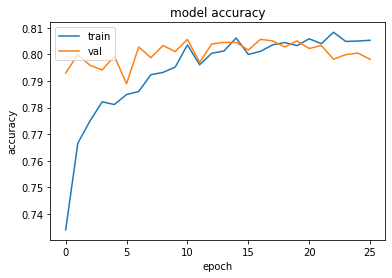

In [117]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [227]:
prediction = model.predict(test)
prediction = list(map(lambda x: True if x >= 0.5 else False, prediction))

2022-08-06 16:49:15.382129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [228]:
NN_pred = np.array(prediction)

NN_sub = test_raw[["PassengerId"]].copy()
NN_sub["Transported"] = NN_pred

NN_sub.to_csv(f"./spaceship-titanic/NN_tuned{i}.csv", index=False)

In [65]:
NN_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


# XGBoost

In [142]:
! pip install xgboost

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01


In [156]:
import xgboost as xgb

data = xgb.DMatrix(data=X,label=y)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'learning_rate': 0.1
}


xgb_class = xgb.cv(params=params, dtrain=data, nfold=5, metrics=("error"))

In [157]:
xgb_class

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.192684,0.003716,0.217530,0.006604
1,0.188600,0.004243,0.213388,0.008014
2,0.186213,0.003044,0.210054,0.004240
3,0.183539,0.002898,0.210282,0.008961
4,0.183280,0.002262,0.208557,0.006569
5,0.181209,0.001597,0.207867,0.006400
6,0.180576,0.001776,0.207867,0.007452
7,0.179052,0.001826,0.206832,0.007024
8,0.178707,0.001915,0.205567,0.007548
9,0.178563,0.001828,0.206257,0.006929


In [ ]:
#         'subsample': [0.6, 0.8, 1.0],

In [182]:
params = {
        'learning_rate': [0.1],
        'max_depth': [4, 5, 6, 8],
        'n_estimators': [50, 100, 200],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'subsample': [0.7, 0.8, 0.9]
        }

xgb_model = xgb.XGBClassifier(random_state=123, objective='binary:logistic')

xgb_grid = GridSearchCV(xgb_model, params, n_jobs=-1, cv=5, verbose=2, refit=True)
xgb_grid.fit(X,y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.1], 'max_depth': [4, 5, 6, 8],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             verbose=2)

In [186]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'subsample': 0.8}

In [190]:
xgb_pred = xgb_grid.best_estimator_.predict(test)
xgb_pred = list(map(lambda x: True if x >= 0.5 else False, prediction))

xgb_sub = test_raw[["PassengerId"]].copy()
xgb_sub["Transported"] = xgb_pred

xgb_sub.to_csv("./spaceship-titanic/xgb_first.csv", index=False)

In [191]:
xgb_sub.Transported

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276     True
Name: Transported, Length: 4277, dtype: bool